In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta  

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy 
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func , inspect
from sqlalchemy import desc
from sqlalchemy.orm import sessionmaker
import pandas

In [4]:
! dir

 Volume in drive C has no label.
 Volume Serial Number is 6C06-A0C3

 Directory of C:\Users\Sridevi\Desktop\Climate_Analysis_Exploration_sqlAlchemy\solved

02/19/2023  07:17 PM    <DIR>          .
02/19/2023  07:17 PM    <DIR>          ..
02/19/2023  07:17 PM    <DIR>          .ipynb_checkpoints
02/19/2023  07:17 PM             5,299 app.py
02/19/2023  07:17 PM            56,884 climate_starter.ipynb
02/19/2023  07:17 PM                 0 hawaii.sqlite
02/19/2023  07:17 PM            20,767 temp_analysis_bonus_1_starter.ipynb
02/19/2023  07:17 PM            65,186 temp_analysis_bonus_2_starter.ipynb
               5 File(s)        148,136 bytes
               3 Dir(s)  134,155,014,144 bytes free


# Reflect Tables into SQLAlchemy ORM

In [5]:
# create engine to hawaii.sqlite

engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine , reflect = True)

In [7]:
# View all of the classes that automap found
#dir(Base.classes)
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)


In [11]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Using the inspector to print the column names within the 'Measurement' table and its types
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Using the inspector to print the column names within the 'Station' table and its types
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
  
recent_date = session.query(func.max(Measurement.date)).scalar()


recent_date_minus_year = (datetime.strptime(recent_date, '%Y-%m-%d') - relativedelta(years=1)).strftime('%Y-%m-%d')
print(recent_date_minus_year)
print(recent_date)

2016-08-23
2017-08-23


In [15]:

# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
qry = session.query(Measurement).filter(Measurement.date.between(recent_date_minus_year,recent_date)).all()





In [16]:

Session = sessionmaker(bind = engine)
session = Session()
 
#SQLAlCHEMY ORM QUERY TO FETCH ALL RECORDS
df = pandas.read_sql_query(
     #sql = session.query(Measurement).statement,
     sql = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date.between(recent_date_minus_year,recent_date)).statement,
     con = engine
 )

#set the index to the date column
df.set_index('date', inplace=True)
 
#Sort the DataFrame values by `date`
sort_date_df = df.sort_values("date")
print(sort_date_df)








            prcp
date            
2016-08-23  0.00
2016-08-23   NaN
2016-08-23  1.79
2016-08-23  0.05
2016-08-23  0.15
...          ...
2017-08-22  0.00
2017-08-23  0.00
2017-08-23  0.00
2017-08-23  0.08
2017-08-23  0.45

[2230 rows x 1 columns]


Text(0, 0.5, 'inches')

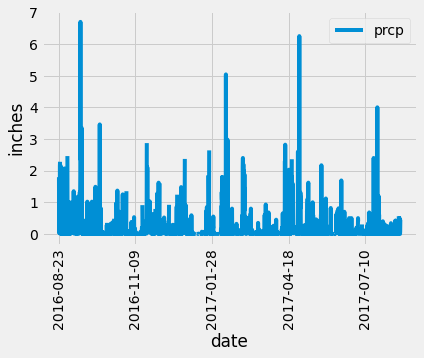

In [29]:
#Plot the results by using the DataFrame `plot` method
sort_date_df.reset_index().plot(x='date' , y= 'prcp',rot = 90)
plt.xlabel("date")
plt.ylabel("inches")


In [18]:
#Use Pandas to print the summary statistics for the precipitation data
print(df.describe())

              prcp
count  2021.000000
mean      0.177279
std       0.461190
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
Session = sessionmaker(bind = engine)
session = Session()
 
#SQLAlCHEMY ORM QUERY TO FETCH ALL RECORDS

qry2 = session.query(func.count(Station.station)).scalar()
# qry1 = session.query(Station).all()
# for each in qry1:
#     #print(each.id, each.station , each.name , each.latitude , each.longitude , each.elevation)
#     print(each.name )

print(f"Total number of stations:{qry2}")


Total number of stations:9


In [20]:
# List the stations and the counts in descending order.
active_station_desc_qry = session.query(Measurement.station ,func.count(Measurement.id)).group_by(Measurement.station ).order_by(desc(func.count(Measurement.id))).all()
active_station_desc_qry


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

active_station_qry = session.query(Measurement.station ,func.count(Measurement.id)).group_by(Measurement.station ).order_by(desc(func.count(Measurement.id))).first()
active_station_qry



('USC00519281', 2772)

In [22]:
# Which station id has the highest number of observations?

highest_observation_station_qry = session.query(Measurement.station ,func.sum(Measurement.tobs)).group_by(Measurement.station ).order_by(desc(func.count(Measurement.tobs))).first()
highest_observation_station_qry 


('USC00519281', 198652.0)

In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station_filter_qry =session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station =='USC00519281').all()
active_station_filter_qry

[(54.0, 85.0, 71.66378066378067)]

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#latest date


recent_date_temp = session.query(func.max(Measurement.date)).scalar()


recent_date_minus_year_temp = (datetime.strptime(recent_date_temp, '%Y-%m-%d') - relativedelta(years=1)).strftime('%Y-%m-%d')

In [25]:
# Filter by the station with the highest number of observations
df_station = pandas.read_sql_query(
         sql = session.query(Measurement.date, Measurement.tobs).
    filter(Measurement.date.between(recent_date_minus_year_temp,recent_date_temp, ) ,Measurement.station =='USC00519281').statement,
    con = engine)

print(df_station)                                                                  
                                                                    

           date  tobs
0    2016-08-23  77.0
1    2016-08-24  77.0
2    2016-08-25  80.0
3    2016-08-26  80.0
4    2016-08-27  75.0
..          ...   ...
347  2017-08-14  77.0
348  2017-08-15  77.0
349  2017-08-16  76.0
350  2017-08-17  76.0
351  2017-08-18  79.0

[352 rows x 2 columns]


Text(0, 0.5, 'Frequency')

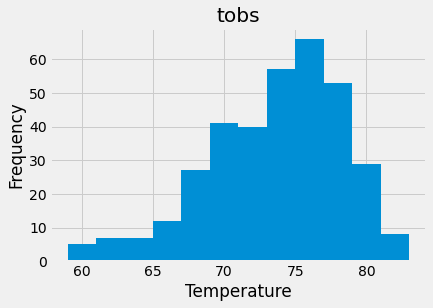

In [26]:
#Plot the results as a histogram with `bins=12
df_station.hist(column='tobs', bins=12);
plt.xlabel("Temperature")
plt.ylabel("Frequency")


# Close session

In [27]:
# Close Session
session.close()